## 知識情報学第14回サンプルプログラム ex14.ipynb
- Programmed by Ken-ichi Fukui
- Last updated: 2022/01/25
- Checked with Python 3.9, tensorflow 2.8
- MIT Lisence

## Kerasを用いたMINISTデータの識別
- AutoEncoderによる事前学習+教師あり学習による識別器の学習
- Keras: https://keras.io/ja/
- Tensorflowのインストール: https://www.tensorflow.org/install/pip
  - Windowsは別途，Microsoft Visual C++の再頒布可能パッケージのインストールが必要?
  - AppleシリコンMacの場合は，tensorflow-metalもあるがまだ不安定なため，Google colabを推奨

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os, struct
import numpy as np


2024-02-04 18:45:49.603698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### MNISTデータの読み込み

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 2次元(28 x 28画素)から1次元（784画素）に変換
X_train = X_train.reshape(X_train.shape[0], 28*28, 1)
X_test = X_test.reshape(X_test.shape[0], 28*28, 1)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
X_train.shape

60000 train samples
10000 test samples


(60000, 784, 1)

In [3]:
# 学習データとテストデータは最初のn_train_data, n_test_data個用いる
n_training_data = 1000
n_test_data = 1000

X_trn = X_train[:n_training_data][:]
y_trn = y_train[:n_training_data]
X_tst = X_test[:n_test_data][:]
y_tst = y_test[:n_test_data]

# 値の範囲を[0,1]に変換 (Keras用)
X_trn = X_trn.astype('float32')/255
X_tst = X_tst.astype('float32')/255

# One-hot encoderによりクラスラベルをバイナリに変換 (Keras用)
# 例：1 -> [1,0,...,0], 2 -> [0,1,0,...]
y_trn = utils.to_categorical(y_trn)
y_tst = utils.to_categorical(y_tst)

# 入力データの次元数(=784画素)を取得
n_dim = X_trn.shape[1]

# 出力クラス数(=10クラス)
n_out = y_trn.shape[1]

n_dim, n_out

(784, 10)

### 学習履歴をプロットする関数

In [4]:
# Accuracyの履歴のプロット
def plot_history_acc(rec):
    plt.plot(rec.history['accuracy'],"o-",label="train") 
    plt.plot(rec.history['val_accuracy'],"o-",label="test") 
    plt.title('accuracy history')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
    
# 損失関数値の履歴のプロット
def plot_history_loss(rec):
    plt.plot(rec.history['loss'],"o-",label="train",)
    plt.plot(rec.history['val_loss'],"o-",label="test")
    plt.title('loss history')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()

### AutoEncoderの構築
- ReLU（活性化関数）: f(x) = max(0,x)

### 課題1(a). 中間層の数を増やしてDNNを実装

In [6]:
ae = Sequential()
ae.add(Dense(500, input_dim=n_dim, activation='relu', name='encoder'))
ae.add(Dropout(0.5))
ae.add(Dense(256, activation='relu'))
ae.add(Dense(128, activation='relu'))
ae.add(Dense(64, activation='relu', name='encoder_out'))
# 出力層
ae.add(Dense(n_dim, activation='relu'))

# 損失関数にMean Squared Error（平均二乗誤差），パラメータの最適化にAdamを設定
ae.compile(loss='mse', optimizer='adam')

# 学習
records_ae = ae.fit(X_trn, X_trn,
                    epochs=250,
                    batch_size=200,
                    shuffle=True,
                    validation_data=(X_tst, X_tst))


Epoch 1/250
5/5 [==============================] - 1s 58ms/step - loss: 0.0986 - val_loss: 0.0872
Epoch 2/250
5/5 [==============================] - 0s 24ms/step - loss: 0.0862 - val_loss: 0.0771
Epoch 3/250
5/5 [==============================] - 0s 29ms/step - loss: 0.0759 - val_loss: 0.0699
Epoch 4/250
5/5 [==============================] - 0s 24ms/step - loss: 0.0691 - val_loss: 0.0659
Epoch 5/250
5/5 [==============================] - 0s 24ms/step - loss: 0.0652 - val_loss: 0.0632
Epoch 6/250
5/5 [==============================] - 0s 23ms/step - loss: 0.0623 - val_loss: 0.0609
Epoch 7/250
5/5 [==============================] - 0s 24ms/step - loss: 0.0596 - val_loss: 0.0588
Epoch 8/250
5/5 [==============================] - 0s 26ms/step - loss: 0.0567 - val_loss: 0.0563
Epoch 9/250
5/5 [==============================] - 0s 25ms/step - loss: 0.0535 - val_loss: 0.0535
Epoch 10/250
5/5 [==============================] - 0s 24ms/step - loss: 0.0504 - val_loss: 0.0506
Epoch 11/250
5/5 [=

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Dense)             (None, 500)               392500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               128256    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 encoder_out (Dense)         (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 784)               50960     
                                                                 
Total params: 612868 (2.34 MB)
Trainable params: 61286

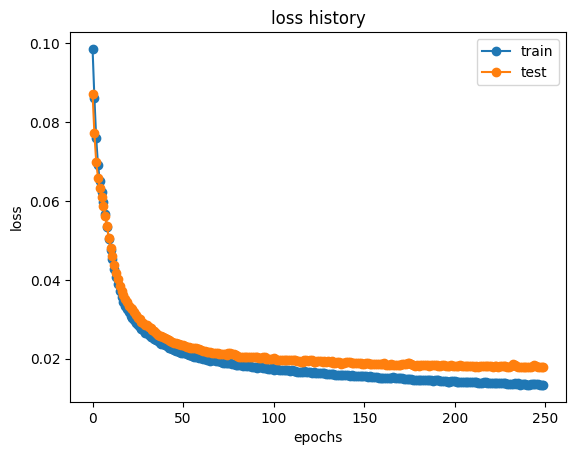

In [7]:
# 学習済み重みの保存
ae.save_weights('autoencoder.h5')
# ネットワークの概要
ae.summary()
# 損失関数値の履歴のプロット
plot_history_loss(records_ae)

### AutoEncoderによる再構成画像の表示

32/32 [==============================] - 0s 2ms/step


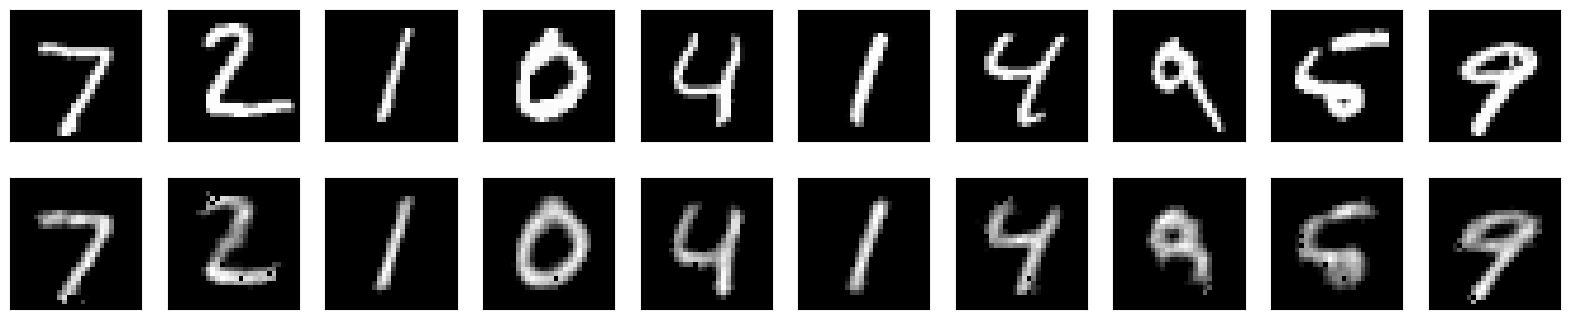

In [8]:
# テスト画像をAutoEncoderで変換
decoded_imgs = ae.predict(X_tst)

n = 10 #表示枚数
plt.figure(figsize=(20, 4))
for i in range(n):
    # 元画像の表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_tst[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 再構成画像の表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### AutoEncoderの学習結果を用いて深層ニューラルネットを構成（DNN）

In [9]:
# AutoEncoderの学習結果（Encoderの学習済み重み）を取得
h = ae.get_layer('encoder_out').output
# 最終段にクラス数の分の出力を持つsoftmax関数を追加
y = Dense(n_out, activation='softmax', name='predictions')(h)

# 入力から出力層までを繋ぐNNモデルを生成
dnn = Model(inputs=ae.inputs, outputs=y)

# 損失関数は交差エントロピーを使用． 最近は平均二乗誤差ではなく交差エントロピーが用いられている．
dnn.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

records_dnn = dnn.fit(X_trn, y_trn,
                epochs=50,
                batch_size=200,
                shuffle=True,
                validation_data=(X_tst, y_tst))

Epoch 1/50
5/5 [==============================] - 1s 72ms/step - loss: 4.2941 - accuracy: 0.1520 - val_loss: 2.1921 - val_accuracy: 0.2840
Epoch 2/50
5/5 [==============================] - 0s 29ms/step - loss: 2.0078 - accuracy: 0.3190 - val_loss: 1.8427 - val_accuracy: 0.3630
Epoch 3/50
5/5 [==============================] - 0s 25ms/step - loss: 1.7400 - accuracy: 0.4390 - val_loss: 1.6326 - val_accuracy: 0.4710
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 1.4833 - accuracy: 0.5390 - val_loss: 1.4057 - val_accuracy: 0.5590
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 1.2183 - accuracy: 0.6440 - val_loss: 1.2178 - val_accuracy: 0.6040
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 1.0253 - accuracy: 0.7000 - val_loss: 1.0418 - val_accuracy: 0.6600
Epoch 7/50
5/5 [==============================] - 0s 20ms/step - loss: 0.7969 - accuracy: 0.7790 - val_loss: 0.8837 - val_accuracy: 0.6970
Epoch 8/50
5/5 [===========

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Dense)             (None, 500)               392500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               128256    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 encoder_out (Dense)         (None, 64)                8256      
                                                                 
 predictions (Dense)         (None, 10)                650   

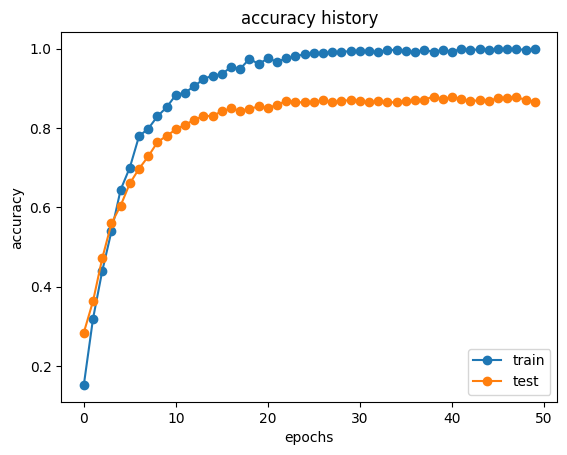

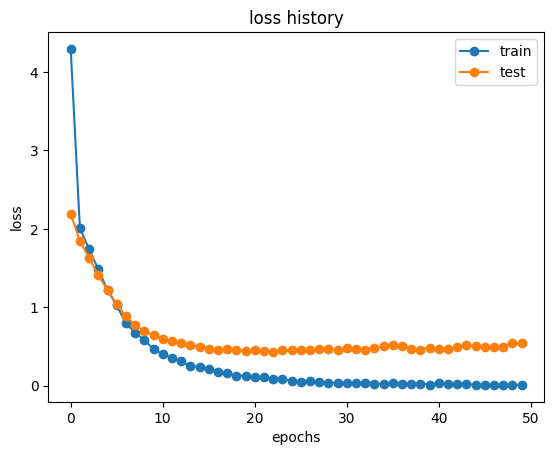

In [10]:
# ネットワークの概要
dnn.summary()
# 学習履歴のプロット
plot_history_acc(records_dnn)
plot_history_loss(records_dnn)

### 課題1(b) AutoEncoderを使わない中間層1層の多層パーセプトロン（MLP）を実装

In [18]:
# モデルパラメータ
input_dim = 784
hidden_units = 128
output_units = 10

# モデルの構築
mlp = Sequential([
    Dense(hidden_units, input_dim=input_dim, activation='relu'),
    Dense(output_units, activation='softmax')
])

# モデルのコンパイル
mlp.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# モデルのサマリー表示
mlp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
records_mlp = mlp.fit(X_trn, y_trn,
                    epochs=250,
                    batch_size=200,
                    shuffle=True,
                    validation_data=(X_tst, y_tst))

Epoch 1/250
5/5 [==============================] - 1s 42ms/step - loss: 2.1379 - accuracy: 0.2990 - val_loss: 1.8882 - val_accuracy: 0.5450
Epoch 2/250
5/5 [==============================] - 0s 19ms/step - loss: 1.5849 - accuracy: 0.7140 - val_loss: 1.5159 - val_accuracy: 0.6860
Epoch 3/250
5/5 [==============================] - 0s 12ms/step - loss: 1.1871 - accuracy: 0.7950 - val_loss: 1.2163 - val_accuracy: 0.7180
Epoch 4/250
5/5 [==============================] - 0s 11ms/step - loss: 0.8948 - accuracy: 0.8280 - val_loss: 1.0000 - val_accuracy: 0.7500
Epoch 5/250
5/5 [==============================] - 0s 10ms/step - loss: 0.7026 - accuracy: 0.8550 - val_loss: 0.8623 - val_accuracy: 0.7610
Epoch 6/250
5/5 [==============================] - 0s 10ms/step - loss: 0.5770 - accuracy: 0.8710 - val_loss: 0.7629 - val_accuracy: 0.7920
Epoch 7/250
5/5 [==============================] - 0s 10ms/step - loss: 0.4915 - accuracy: 0.8840 - val_loss: 0.6959 - val_accuracy: 0.8070
Epoch 8/250
5/5 [===

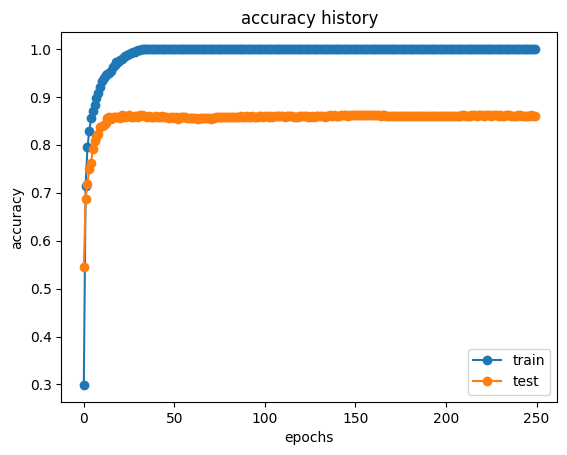

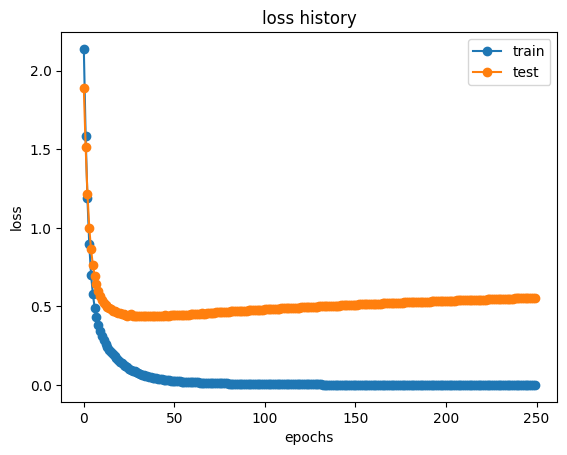

In [20]:
plot_history_acc(records_mlp)
plot_history_loss(records_mlp)

### 課題1(c) CNNを実装
- 参考：VGG-likeなconvnet
  - https://faroit.com/keras-docs/0.2.0/examples/

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

X_trn_cnn = X_trn.reshape(X_trn.shape[0], 28, 28, 1)
X_tst_cnn = X_tst.reshape(X_tst.shape[0], 28, 28, 1)

# モデルパラメータ
input_shape = (28, 28, 1)  # 入力画像の形状
num_classes = 10  # クラスの数

# CNNモデルの構築
cnn = Sequential([
    # 畳み込み層1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    # プーリング層1
    MaxPooling2D(pool_size=(2, 2)),
    # 畳み込み層2
    Conv2D(64, (3, 3), activation='relu'),
    # プーリング層2
    MaxPooling2D(pool_size=(2, 2)),
    # Flatten層: 2Dから1Dへ変換
    Flatten(),
    # 全結合層
    Dense(128, activation='relu'),
    # 出力層
    Dense(num_classes, activation='softmax')
])

# モデルのコンパイル
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# モデルのサマリー表示
cnn.summary()

# モデルの訓練
records_cnn = cnn.fit(X_trn_cnn, y_trn,
                      epochs=100,  # エポック数
                      batch_size=200,  # バッチサイズ
                      shuffle=True,
                      validation_data=(X_tst_cnn, y_tst))


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 1600)              0         
                                                                 
 dense_26 (Dense)            (None, 128)             

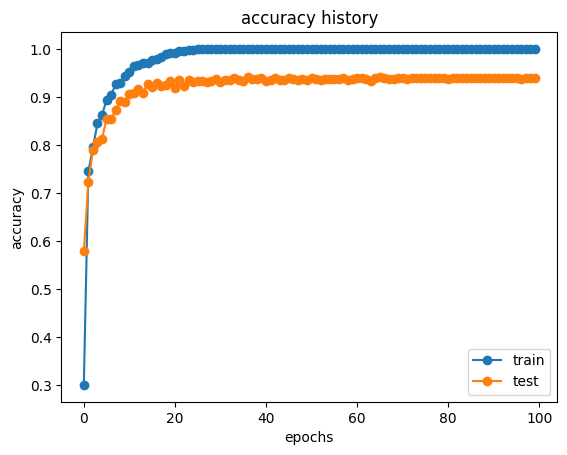

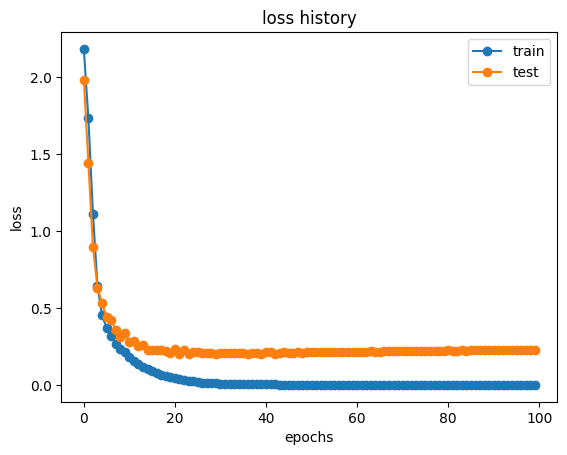

In [33]:
plot_history_acc(records_cnn)
plot_history_loss(records_cnn)

## 課題２

### 多層パーセプトロンにおける中間層の数について
- 中間層は多い方がaccuracyは多少改善しているが、testのlossがより大きくなっており、過学習しやすくなっていることが見受けられる

Epoch 1/250
5/5 [==============================] - 1s 58ms/step - loss: 1.9572 - accuracy: 0.4860 - val_loss: 1.5098 - val_accuracy: 0.6790
Epoch 2/250
5/5 [==============================] - 0s 19ms/step - loss: 0.9832 - accuracy: 0.8140 - val_loss: 0.8195 - val_accuracy: 0.7530
Epoch 3/250
5/5 [==============================] - 0s 18ms/step - loss: 0.4854 - accuracy: 0.8550 - val_loss: 0.5826 - val_accuracy: 0.8110
Epoch 4/250
5/5 [==============================] - 0s 18ms/step - loss: 0.3305 - accuracy: 0.9000 - val_loss: 0.5338 - val_accuracy: 0.8300
Epoch 5/250
5/5 [==============================] - 0s 17ms/step - loss: 0.2512 - accuracy: 0.9250 - val_loss: 0.4833 - val_accuracy: 0.8410
Epoch 6/250
5/5 [==============================] - 0s 19ms/step - loss: 0.1948 - accuracy: 0.9470 - val_loss: 0.4904 - val_accuracy: 0.8320
Epoch 7/250
5/5 [==============================] - 0s 19ms/step - loss: 0.1428 - accuracy: 0.9580 - val_loss: 0.4481 - val_accuracy: 0.8600
Epoch 8/250
5/5 [===

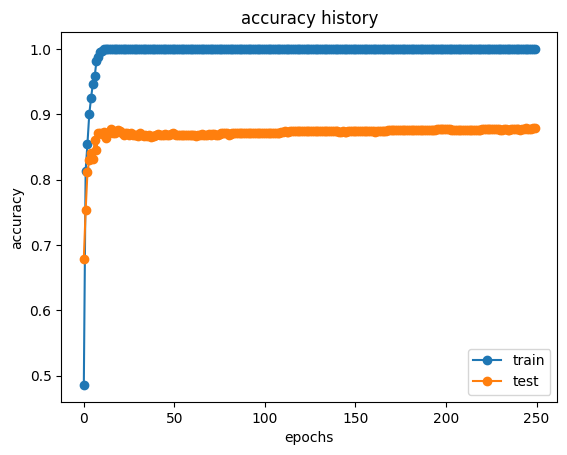

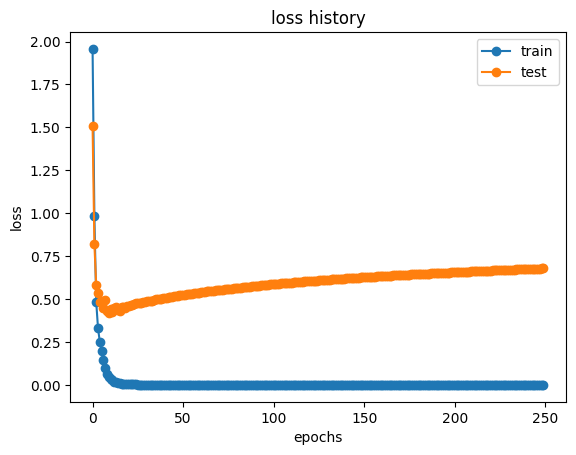

In [37]:
# モデルパラメータ
input_dim = 784
output_units = 10

# モデルの構築
mlp = Sequential([
    Dense(512, input_dim=input_dim, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(output_units, activation='softmax')
])

# モデルのコンパイル
mlp.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

records_mlp = mlp.fit(X_trn, y_trn,
                    epochs=250,
                    batch_size=200,
                    shuffle=True,
                    validation_data=(X_tst, y_tst))

plot_history_acc(records_mlp)
plot_history_loss(records_mlp)

### 多層パーセプトロンにおけるノード数について
- ノード数が少ないほど、過学習が軽減されているように見られる。今回の実験でははっきりと見られなかったが、ノード数が少ないと表現力が低下し、複雑なタスクではaccuracyが低下するものと思われる。
- ノード数が少ないほど、学習時間は短くなった。

Epoch 1/250
5/5 [==============================] - 1s 57ms/step - loss: 2.0991 - accuracy: 0.3060 - val_loss: 1.8660 - val_accuracy: 0.5250
Epoch 2/250
5/5 [==============================] - 0s 15ms/step - loss: 1.5200 - accuracy: 0.6450 - val_loss: 1.3545 - val_accuracy: 0.6270
Epoch 3/250
5/5 [==============================] - 0s 14ms/step - loss: 0.9572 - accuracy: 0.7780 - val_loss: 0.9178 - val_accuracy: 0.7430
Epoch 4/250
5/5 [==============================] - 0s 14ms/step - loss: 0.5823 - accuracy: 0.8610 - val_loss: 0.6732 - val_accuracy: 0.8060
Epoch 5/250
5/5 [==============================] - 0s 14ms/step - loss: 0.3989 - accuracy: 0.9030 - val_loss: 0.5514 - val_accuracy: 0.8300
Epoch 6/250
5/5 [==============================] - 0s 14ms/step - loss: 0.3012 - accuracy: 0.9210 - val_loss: 0.5016 - val_accuracy: 0.8300
Epoch 7/250
5/5 [==============================] - 0s 15ms/step - loss: 0.2380 - accuracy: 0.9430 - val_loss: 0.4856 - val_accuracy: 0.8360
Epoch 8/250
5/5 [===

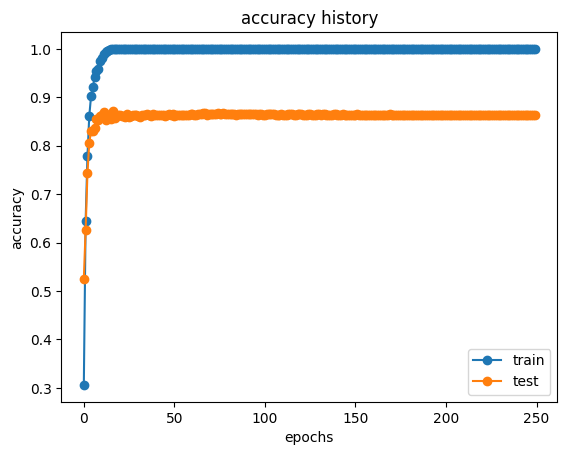

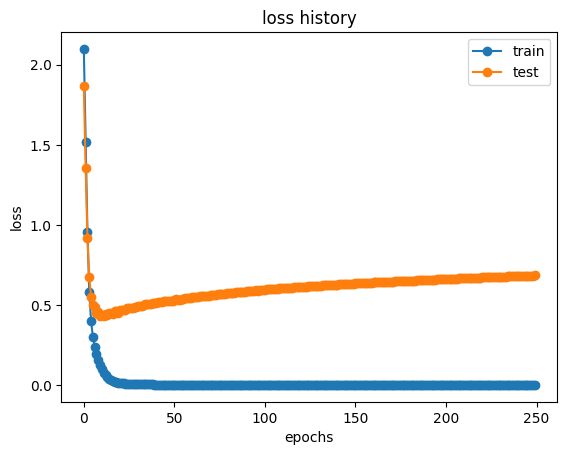

In [38]:
# モデルパラメータ
input_dim = 784
output_units = 10

# モデルの構築
mlp = Sequential([
    Dense(256, input_dim=input_dim, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(output_units, activation='softmax')
])

# モデルのコンパイル
mlp.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

records_mlp = mlp.fit(X_trn, y_trn,
                    epochs=250,
                    batch_size=200,
                    shuffle=True,
                    validation_data=(X_tst, y_tst))

plot_history_acc(records_mlp)
plot_history_loss(records_mlp)

Epoch 1/250
5/5 [==============================] - 1s 49ms/step - loss: 2.2198 - accuracy: 0.2420 - val_loss: 2.1002 - val_accuracy: 0.3530
Epoch 2/250
5/5 [==============================] - 0s 13ms/step - loss: 1.8920 - accuracy: 0.5010 - val_loss: 1.8293 - val_accuracy: 0.4860
Epoch 3/250
5/5 [==============================] - 0s 12ms/step - loss: 1.5472 - accuracy: 0.6180 - val_loss: 1.5425 - val_accuracy: 0.5820
Epoch 4/250
5/5 [==============================] - 0s 16ms/step - loss: 1.2076 - accuracy: 0.6970 - val_loss: 1.2676 - val_accuracy: 0.6650
Epoch 5/250
5/5 [==============================] - 0s 12ms/step - loss: 0.9191 - accuracy: 0.7840 - val_loss: 1.0410 - val_accuracy: 0.7220
Epoch 6/250
5/5 [==============================] - 0s 15ms/step - loss: 0.6947 - accuracy: 0.8510 - val_loss: 0.8707 - val_accuracy: 0.7620
Epoch 7/250
5/5 [==============================] - 0s 16ms/step - loss: 0.5449 - accuracy: 0.8740 - val_loss: 0.7482 - val_accuracy: 0.7870
Epoch 8/250
5/5 [===

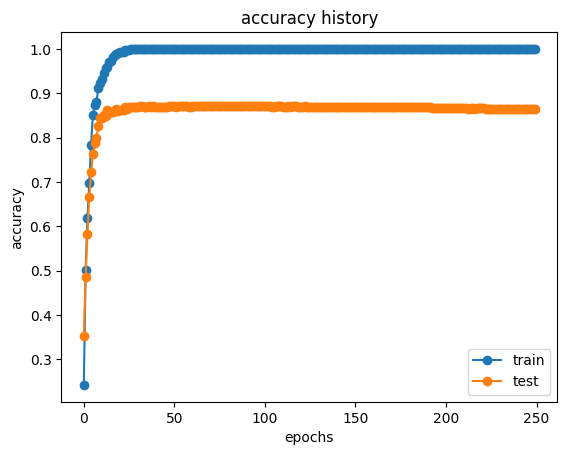

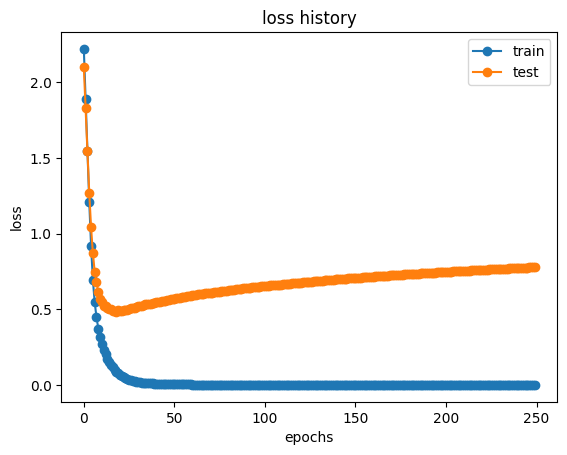

In [39]:
# モデルパラメータ
input_dim = 784
output_units = 10

# モデルの構築
mlp = Sequential([
    Dense(128, input_dim=input_dim, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(output_units, activation='softmax')
])

# モデルのコンパイル
mlp.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

records_mlp = mlp.fit(X_trn, y_trn,
                    epochs=250,
                    batch_size=200,
                    shuffle=True,
                    validation_data=(X_tst, y_tst))

plot_history_acc(records_mlp)
plot_history_loss(records_mlp)

### CNNのカーネルサイズについて
- カーネルサイズを2*2に変更すると、accuracyが低下した。これは表現できるフィルタの種類が少なくなり、複雑な表現を学習しにくくなったためだと考えられる。
- カーネルサイズを4*4に変更しても、accuracyはほとんど変わらなかった。MNISTデータセットについては、3*3のフィルタによって十分に表現可能な複雑さしかないと考えられる。

In [40]:
# モデルパラメータ
input_shape = (28, 28, 1)  # 入力画像の形状
num_classes = 10  # クラスの数

# CNNモデルの構築
cnn = Sequential([
    # 畳み込み層1
    Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape),
    # プーリング層1
    MaxPooling2D(pool_size=(2, 2)),
    # 畳み込み層2
    Conv2D(64, (2, 2), activation='relu'),
    # プーリング層2
    MaxPooling2D(pool_size=(2, 2)),
    # Flatten層: 2Dから1Dへ変換
    Flatten(),
    # 全結合層
    Dense(128, activation='relu'),
    # 出力層
    Dense(num_classes, activation='softmax')
])

# モデルのコンパイル
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# モデルのサマリー表示
cnn.summary()

# モデルの訓練
records_cnn = cnn.fit(X_trn_cnn, y_trn,
                      epochs=100,  # エポック数
                      batch_size=200,  # バッチサイズ
                      shuffle=True,
                      validation_data=(X_tst_cnn, y_tst))


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 27, 27, 32)        160       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 2304)              0         
                                                                 
 dense_45 (Dense)            (None, 128)             

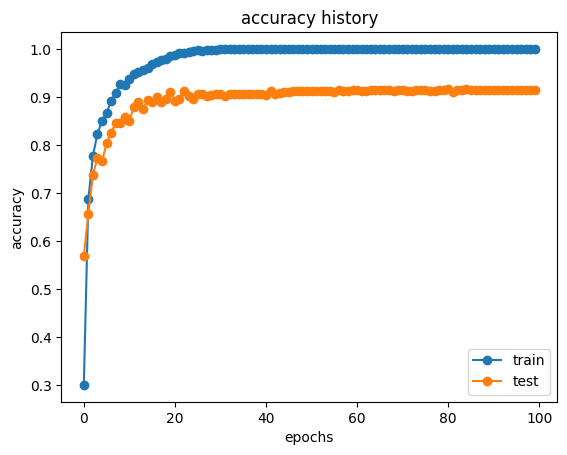

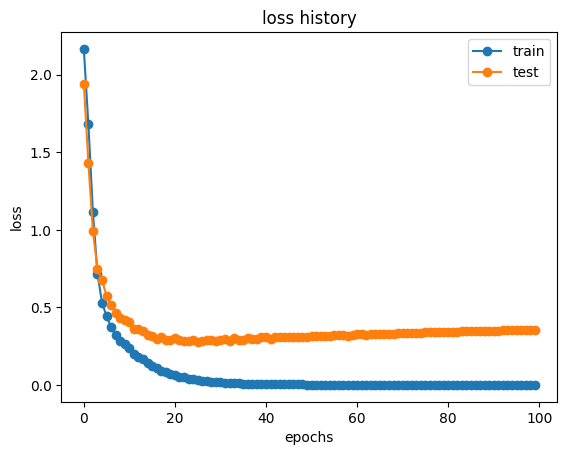

In [41]:
plot_history_acc(records_cnn)
plot_history_loss(records_cnn)

In [42]:
# モデルパラメータ
input_shape = (28, 28, 1)  # 入力画像の形状
num_classes = 10  # クラスの数

# CNNモデルの構築
cnn = Sequential([
    # 畳み込み層1
    Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=input_shape),
    # プーリング層1
    MaxPooling2D(pool_size=(2, 2)),
    # 畳み込み層2
    Conv2D(64, (4, 4), activation='relu'),
    # プーリング層2
    MaxPooling2D(pool_size=(2, 2)),
    # Flatten層: 2Dから1Dへ変換
    Flatten(),
    # 全結合層
    Dense(128, activation='relu'),
    # 出力層
    Dense(num_classes, activation='softmax')
])

# モデルのコンパイル
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# モデルのサマリー表示
cnn.summary()

# モデルの訓練
records_cnn = cnn.fit(X_trn_cnn, y_trn,
                      epochs=100,  # エポック数
                      batch_size=200,  # バッチサイズ
                      shuffle=True,
                      validation_data=(X_tst_cnn, y_tst))


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 1024)              0         
                                                                 
 dense_47 (Dense)            (None, 128)             

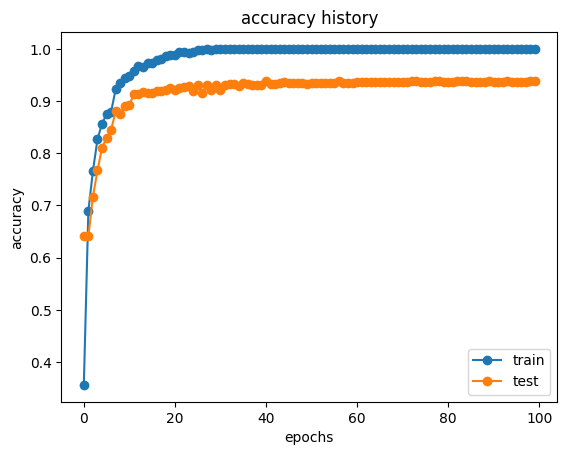

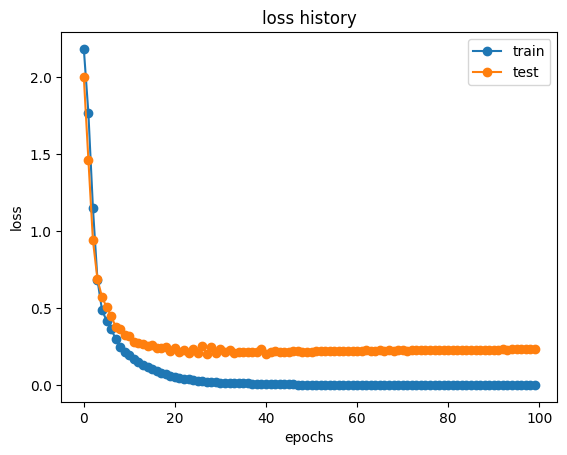

In [43]:
plot_history_acc(records_cnn)
plot_history_loss(records_cnn)